In [1]:
from fastai.vision.all import *

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [4]:
im3 = Image.open(threes[1])
# Image.open(threes[2])
# Image.open(threes[3])
im3

In [5]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:26,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [6]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
# len(three_tensors), len(seven_tensors)
# three_tensors.shape, seven_tensors.shape 

6131


<Axes: >

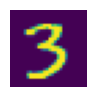

In [7]:
print(len(three_tensors))
show_image(three_tensors[1])

In [8]:
# mean calc : required float conversion : general scaling 0 : 1 

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
print(stacked_threes.shape, stacked_sevens.shape)
print(stacked_threes.ndim )

torch.Size([6131, 28, 28]) torch.Size([6265, 28, 28])
3


<Axes: >

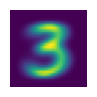

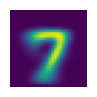

In [9]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)
show_image(mean3);
show_image(mean7)

In [10]:
# MAE : mean absoule error 
# RMSE : root mean of squared error 
dist3_mae = (stacked_threes[0] - mean3).abs().mean()
print('dist3 MAE: ',dist3_mae)
dist3_rmse = ((stacked_threes[0] - mean3)**2).mean().sqrt() 
print('dist3 RMSE: ',dist3_rmse)

dist3 MAE:  tensor(0.1074)
dist3 RMSE:  tensor(0.1912)


In [11]:
# MAE loss using builtin torch method
F.l1_loss(stacked_threes[0], mean7), F.l1_loss(stacked_threes[0], mean3)

(tensor(0.1441), tensor(0.1074))

In [12]:
# RMSE loss using built-in torch method : torch.nn.functional
F.mse_loss(stacked_threes[0], mean7), F.mse_loss(stacked_threes[0], mean3)

(tensor(0.0773), tensor(0.0366))

In [13]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)
# arr, tns
# tns[0]
# tns[0,1:]
# tns.type()

tns + 1 , tns * 1.25, tns / 1.1

(tensor([[2, 3, 4],
         [5, 6, 7]]),
 tensor([[1.2500, 2.5000, 3.7500],
         [5.0000, 6.2500, 7.5000]]),
 tensor([[0.9091, 1.8182, 2.7273],
         [3.6364, 4.5455, 5.4545]]))

In [14]:
# validation tensors from dataset : model evaulation 
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])    # creating a matrix of image tensors
valid_3_tens = valid_3_tens.float()/255    # converting pixel vals as flaot -> scaling to (0->1)
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [15]:
# fucntion to output tensor : MAE of all images 
def mnist_dist(a,b): return (a-b).abs().mean((-1,-2))
valid_3_dist = mnist_dist(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape, (valid_3_tens - mean3).abs().shape 
# options : cosine similarity, RMSE, euclidian distance 

(tensor([0.1270, 0.1632, 0.1676,  ..., 0.1228, 0.1210, 0.1287]),
 torch.Size([1010]),
 torch.Size([1010, 28, 28]))

In [16]:
# function to reutrn pixel similarity to 3 (using MAE) 
def is_3(x) : return mnist_dist(x, mean3) < mnist_dist(x, mean7)

print(is_3(valid_3_tens))

accuracy_3 = is_3(valid_3_tens).float().mean() 
accuracy_7 = (1- is_3(valid_7_tens).float()).mean() 

print('accuracy 3 :', accuracy_3.item())
print('accuracy 7 :', accuracy_7.item())
print('accuracy overall :', torch.stack([accuracy_3, accuracy_7]).mean())

tensor([ True, False, False,  ...,  True,  True, False])
accuracy 3 : 0.9168316721916199
accuracy 7 : 0.9854085445404053
accuracy overall : tensor(0.9511)


###   machine learning classifier 
1. initialize random wights
2. make predictions -> calculate model accuracy
3. calculate gradient -> calculates change in weights affect on the loss
4. change weights based on gradient calculations
5. re-iterate to step-2

* weight initialize : random weights
* loss : testing the effectiveness of weights
* step : try current weight: increase/decrease weights : calculate direction (inc or dec)
          -> calculating gradient : applying updated weights (inc/dec) : repeat steps
* stop : re-iterate step till : epochs reached, accuracy gets worse, time runs out 
  

In [17]:
# pytorch gradient calculation 

def f(x) : return x**2  # defining the func  
x = tensor(3.).requires_grad_() # calculate gradient at val -> x
y = f(x)
y.backward() 

x, x.grad, y  # x.grad -> gradient of f(x) : calculated at val (x)

(tensor(3., requires_grad=True),
 tensor(6.),
 tensor(9., grad_fn=<PowBackward0>))

In [18]:
# using tensor (rank1 : 1 dim-array) this time 

def g(x) : return (x**2).sum()
x = tensor([3.,4.,5.]).requires_grad_()
y = g(x)
y.backward()

x, x.grad, y

(tensor([3., 4., 5.], requires_grad=True),
 tensor([ 6.,  8., 10.]),
 tensor(50., grad_fn=<SumBackward0>))

In [19]:
time = torch.arange(0,20).float(); time
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1

tensor(15897.9561, grad_fn=<MeanBackward0>)

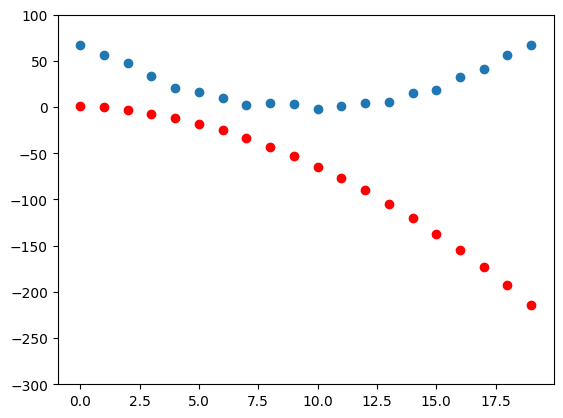

In [20]:
# SGD using dl/ml 

def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

def mse(preds, target) : return ((preds-target)**2).mean()    # loss function 

params = torch.randn(3).requires_grad_()    # tagged to track gradient (weights)
preds = f(time, params)                     # predictions 

def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

show_preds(preds)
mse(preds, speed)

In [21]:
# calc loss 
loss = mse(preds, speed)
loss 

# calc gradients 
loss.backward() 
params.grad

tensor([-41439.7930,  -2669.0671,   -202.4618])

In [22]:
# stepping weights 
lr = 1e-5 
params.data -= params.grad.data * lr 

# params.grad = None
# params.data, params.grad

(tensor(3525.1770, grad_fn=<MeanBackward0>),
 tensor([-0.1119, -1.3093,  1.6215]))

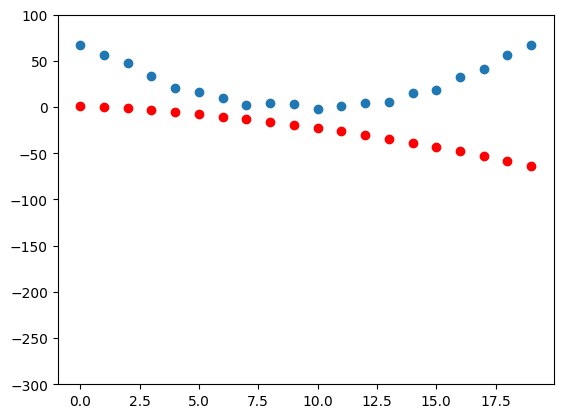

In [23]:
# check loss 

preds = f(time,params)
show_preds(preds)
mse(preds, speed), params.data 

* Ist iteration loss -> tensor(53552.4883, grad_fn=<MeanBackward0>)
* 2nd iteration loss -> tensor(10674.2959, grad_fn=<MeanBackward0>)

In [24]:
def apply_step(params, prnt):
    preds = f(time, params) # predictions 
    loss = mse(preds, speed) # calc loss 
    loss.backward() # calc gradient 
    # stepping weights 
    lr = 1e-5 
    params.data -= params.grad.data * lr 
    params.grad = None 

    if (prnt) : print(loss.item()) 
    return preds 

In [25]:
# run 10 epochs 
for i in range (10) : apply_step(params, true)

3525.177001953125
2792.16455078125
1045.1495361328125
714.5568237304688
651.9945068359375
640.1517333984375
637.9066772460938
637.4776000976562
637.3923950195312
637.3720703125


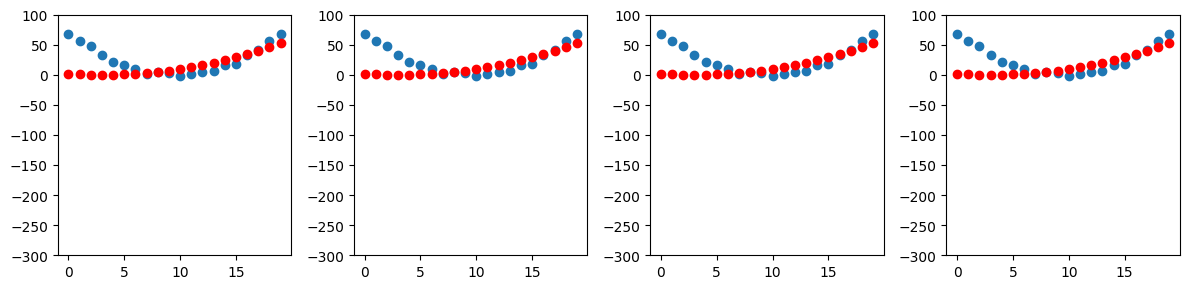

In [26]:
# plot reducing loss 

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [27]:
# MNIST loss function 
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # adding labels for each img 
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [28]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [29]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

# initialize random weight for each pixel 
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)

In [30]:
# y=w*x+b  : w -> weights , b -> bias , y -> parameter